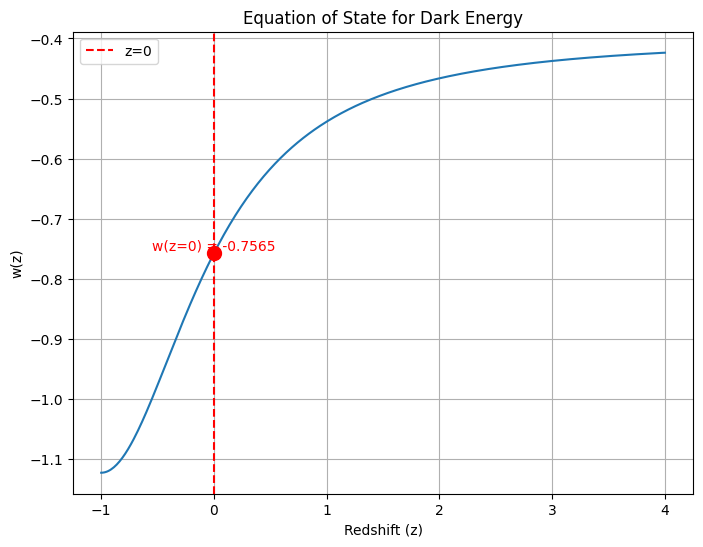

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 H(z) 函数
def H(z, H0, m):
    return H0 / np.sqrt(2) * np.sqrt(1 + (1 + z)**(2 * m))

# 设置参数
H0 = 70  # km/s/Mpc
alpha = 1
beta = 0
n = 1.01
m = 1
c = 1
z = np.linspace(-1, 4, 400)  # 红移范围

H_z = H(z, H0, m)

dot_H = np.gradient(H_z, z)

rde = 3 * c ** 2 * H_z ** 2
pde = -((6**(-1 + n) * alpha * (H_z**2)**(-1 + n) * (3 * (-1 + 2 * n) * (1 + beta) * H_z**2 + n * (2 + beta) * -dot_H*(1+z)*H_z)))
wde = pde / rde

# wde = ((2**(-1 + n) * 3**(-2 + n) * alpha * (H_z**2)**(-2 + n) * (3 * (-1 + 2 * n) * (1 + beta) * H_z**2 - n * (1 + z) * (2 + beta) * H_z * dot_H)) / (c**2 * (-1 + beta + 2 * beta**2)))

# 绘制图像
plt.figure(figsize=(8, 6))
plt.plot(z, wde)
plt.xlabel("Redshift (z)")
plt.ylabel("w(z)")
plt.title("Equation of State for Dark Energy")
plt.grid()  # 添加网格
# 添加 z=0 的垂直线
plt.axvline(x=0, color='r', linestyle='--', label='z=0')
plt.legend()
# 在 z=0 处添加 w(z) 的值
z_zero_idx = np.argmin(np.abs(z))
w_z0 = wde[z_zero_idx]
plt.text(0, w_z0, f"w(z=0) = {w_z0:.4f}", ha='center', va='bottom', color='r')
# 在 z=0 处添加标记点
plt.plot(0, w_z0, 'ro', markersize=10)

plt.show()

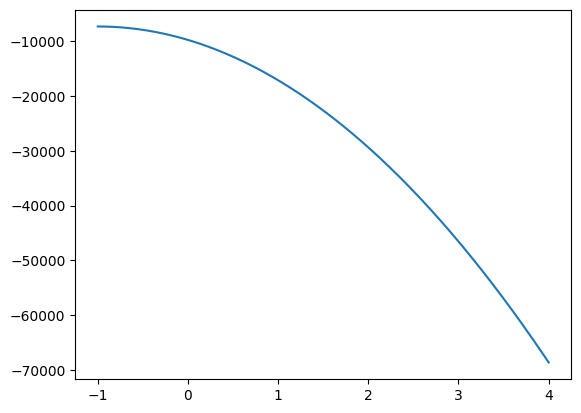

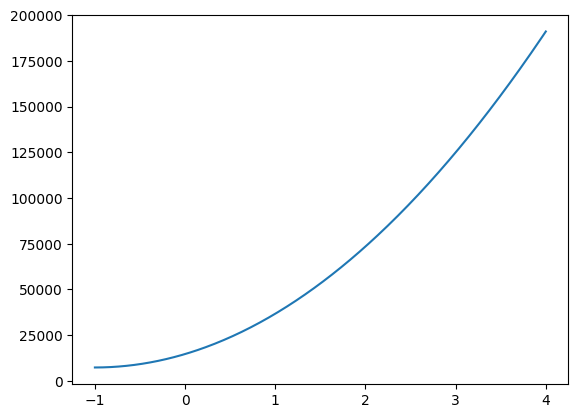

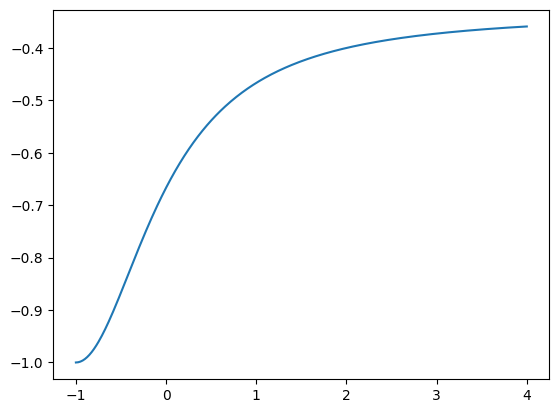

In [18]:
plt.plot(z,pde)
plt.show()
plt.plot(z,rde)
plt.show()
plt.plot(z,pde/rde)

In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp


file_name1 = "ChronometersData.txt"
data=np.loadtxt(file_name1, skiprows=0, usecols = (0,1,2), dtype=np.float32)
# 定义观测数据
z_obs = data[:,0]  # 示例红移
H_obs = data[:,1]  # 观测 H(z)
sigma_H = data[:,2] # 观测误差

# 模型函数
def H_model(params, z_vals):
    n, alpha, m, wde, c = params
    # 定义微分方程与初值，类似之前代码
    def differential_eq(z, y):
        H, dH = y
        term1 = 6 ** (-1 + n) * m * (-1 + 2 * n) * (H**(-2 + 2 * n))
        term2 = 3 * (1 + alpha) * H**2
        term3 = -n * (1 + z) * (2 + alpha) * H * dH
        numerator = term1 * (term2 + term3)
        denominator = wde * (-1 + alpha + 2 * alpha**2)
        rhs = numerator / denominator - 3 * c**2 * H**2
        return [dH, rhs / (n * (1 + z) * (2 + alpha))]
    
    # 解方程
    solution = solve_ivp(differential_eq, [z_vals[0], z_vals[-1]], [70.0, -5.0], t_eval=z_vals)
    return solution.y[0]  # 返回 H(z) 数值

# 定义误差函数
def chi_squared(params):
    H_pred = H_model(params, z_obs)
    chi2 = np.sum(((H_obs - H_pred) / sigma_H) ** 2)
    return chi2

# 初始参数猜测
initial_guess = [1.1, 0.1, 1.0, -1.0, 1.0]

# 优化参数
result = minimize(chi_squared, initial_guess, method='Nelder-Mead')
best_fit_params = result.x

print("Best fit parameters:", best_fit_params)


/tmp/ipykernel_615435/21904865.py:19: RuntimeWarning: invalid value encountered in scalar power
  term1 = 6 ** (-1 + n) * m * (-1 + 2 * n) * (H**(-2 + 2 * n))


ValueError: operands could not be broadcast together with shapes (31,) (9,) 

In [ ]:
import matplotlib.pyplot as plt

# 绘图
z_vals = np.linspace(0, 2, 500)
H_fit = H_model(best_fit_params, z_vals)

plt.errorbar(z_obs, H_obs, yerr=sigma_H, fmt='o', label='Observations')
plt.plot(z_vals, H_fit, label='Best Fit Model')
plt.xlabel('z')
plt.ylabel('H(z)')
plt.legend()
plt.grid()
plt.show()


In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# 加载数据
file_name1 = "ChronometersData.txt"
data = np.loadtxt(file_name1, skiprows=0, usecols=(0, 1, 2), dtype=np.float32)
z_obs = data[:, 0]  # 红移
H_obs = data[:, 1]  # 观测 H(z)
sigma_H = data[:, 2]  # 观测误差

# 模型函数
def H_model(params, z_vals):
    n, alpha, m, wde, c = params
    def differential_eq(z, y):
        H, dH = y
        term1 = 6 ** (-1 + n) * m * (-1 + 2 * n) * (H**(-2 + 2 * n))
        term2 = 3 * (1 + alpha) * H**2
        term3 = -n * (1 + z) * (2 + alpha) * H * dH
        numerator = term1 * (term2 + term3)
        denominator = wde * (-1 + alpha + 2 * alpha**2)
        rhs = numerator / denominator - 3 * c**2 * H**2
        return [dH, rhs / (n * (1 + z) * (2 + alpha))]
    solution = solve_ivp(differential_eq, [z_vals[0], z_vals[-1]], [70.0, -5.0], t_eval=z_vals)
    return solution.y[0]

# 计算 chi-squared
def chi_squared(params):
    H_pred = H_model(params, z_obs)
    chi2 = np.sum(((H_obs - H_pred) / sigma_H) ** 2)
    return chi2

# 初始参数猜测
initial_guess = [1.1, 0.1, 1.0, -1.0, 1.0]

# 优化参数
result = minimize(chi_squared, initial_guess, method='Nelder-Mead')
best_fit_params = result.x

print("Best fit parameters:", best_fit_params)


/tmp/ipykernel_615435/2896220915.py:18: RuntimeWarning: invalid value encountered in scalar power
  term1 = 6 ** (-1 + n) * m * (-1 + 2 * n) * (H**(-2 + 2 * n))


ValueError: operands could not be broadcast together with shapes (31,) (9,) 